# Arctic Penguin Exploration: Unraveling Clusters in the Icy Domain with K-means clustering

![Alt text](https://imgur.com/orZWHly.png)
source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! 

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)
- flipper_length_mm: flipper length (mm)
- body_mass_g: body mass (g)
- sex: penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are three species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**, so your task is to apply your data science skills to help them identify groups in the dataset!

In [218]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Loading and examining the dataset
penguins_df = pd.read_csv("data/penguins.csv")

- Begin by reading in "data/penguins.csv" as a pandas DataFrame called penguins_df, then investigate and clean the dataset by removing the null values and outliers. Save as a cleaned DataFrame called penguins_clean.

In [219]:
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [220]:
penguins_df.shape

(344, 5)

In [221]:
penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


In [222]:
penguins_df.isna().sum().sort_values(ascending=False)

sex                  9
culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
dtype: int64

In [223]:
penguins_clean = penguins_df.dropna(axis=0)
penguins_clean.isna().sum().sort_values(ascending=False)

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [224]:
penguins_clean.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,335.000000,335.000000,335.000000,335.000000
mean,43.988358,17.169552,214.355224,4209.179104
std,5.453430,1.971966,263.253508,803.633495
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.550000,18.700000,213.000000,4787.500000
max,59.600000,21.500000,5000.000000,6300.000000


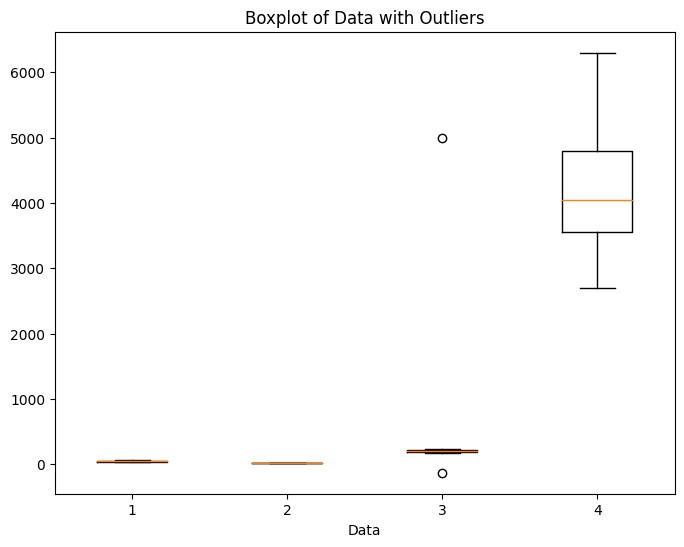

In [225]:
# Visualize using Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(penguins_clean.iloc[:, :-1])  ## Looking for outliers
plt.title('Boxplot of Data with Outliers')
plt.xlabel('Data')
plt.show()

In [226]:
# Choose the column index containing the outliers (3rd column in this case)
column_index = 2 

# Get the values of the chosen column
column_values = penguins_clean.iloc[:, column_index]

# Compute the first quartile (Q1)
Q1 = np.percentile(column_values, 25)

# Compute the third quartile (Q3)
Q3 = np.percentile(column_values, 75)

# Compute the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Original data length:", len(penguins_clean))

# Filter the outliers
penguins_clean = penguins_clean[(column_values >= lower_bound) & (column_values <= upper_bound)]

# Print the original and filtered data lengths
print("Filtered data length:", len(penguins_clean))

Original data length: 335
Filtered data length: 333


- Pre-process the cleaned data using standard scaling and the one-hot encoding to add dummy variables:
    - Create the dummy variables and remove the original categorical feature from the dataset.
    - Scale the data using the standard scaling method.
    - Save the updated data as a new DataFrame called penguins_preprocessed.

In [227]:
penguins_clean.columns

Index(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex'],
      dtype='object')

In [228]:
# Create dummy variables for categorical features
penguins_encoded = pd.get_dummies(penguins_clean, columns=['sex'])
penguins_encoded.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_.,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,0,0,1
1,39.5,17.4,186.0,3800.0,0,1,0
2,40.3,18.0,195.0,3250.0,0,1,0
4,36.7,19.3,193.0,3450.0,0,1,0
5,39.3,20.6,190.0,3650.0,0,0,1


In [229]:
# Drop the original categorical feature
penguins_encoded.drop(columns=['sex_.'], inplace=True)

# Scale the data using standard scaling
scaler = StandardScaler()
penguins_scaled = scaler.fit_transform(penguins_encoded)

# Convert the scaled array back to DataFrame
penguins_preprocessed = pd.DataFrame(penguins_scaled, columns=penguins_encoded.columns)

# Save the preprocessed data to a new DataFrame
penguins_preprocessed.to_csv('penguins_preprocessed.csv', index=False)

- Perform Principal Component Analysis (PCA) on the penguins_preprocessed dataset to determine the desired number of components, considering any component with an explained variance ratio above 10% as a suitable component. Save the number of components as a variable called n_components.
    - Finally, execute PCA using n_components and store the result as penguins_PCA.

In [230]:
# Perform PCA
pca = PCA()
penguins_PCA = pca.fit_transform(penguins_preprocessed)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Determine the number of components with explained variance ratio above 10%
cumulative_variance_ratio = 0
n_components = 0

for i, ratio in enumerate(explained_variance_ratio):
    cumulative_variance_ratio += ratio
    if cumulative_variance_ratio > 0.1:
        n_components = i + 2
        break

print("Desired number of components:", n_components)

# Execute PCA using the desired number of components
pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(penguins_preprocessed)

Desired number of components: 2


- Employ k-means clustering on the penguins_PCA dataset, setting random_state=42, to determine the number of clusters through elbow analysis. Save the optimal number of clusters in a variable called n_cluster.

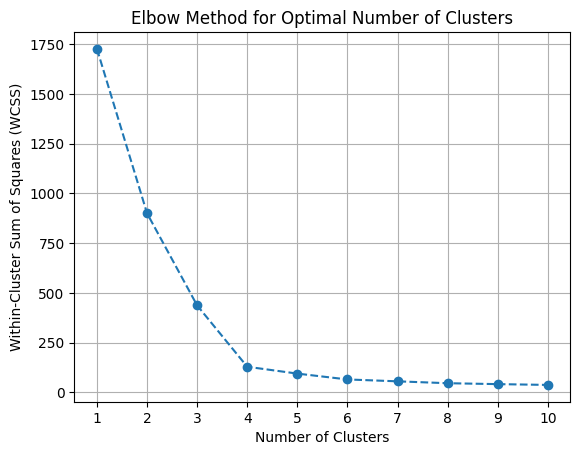

In [231]:
# Initialize an empty list to store the within-cluster sum of squares (inertia)
wcss = []

# Define the range of clusters to try
max_clusters = 10  # You can adjust this based on your dataset

# Perform k-means clustering for different numbers of clusters
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(penguins_PCA)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

Optimal number of clusters: 4


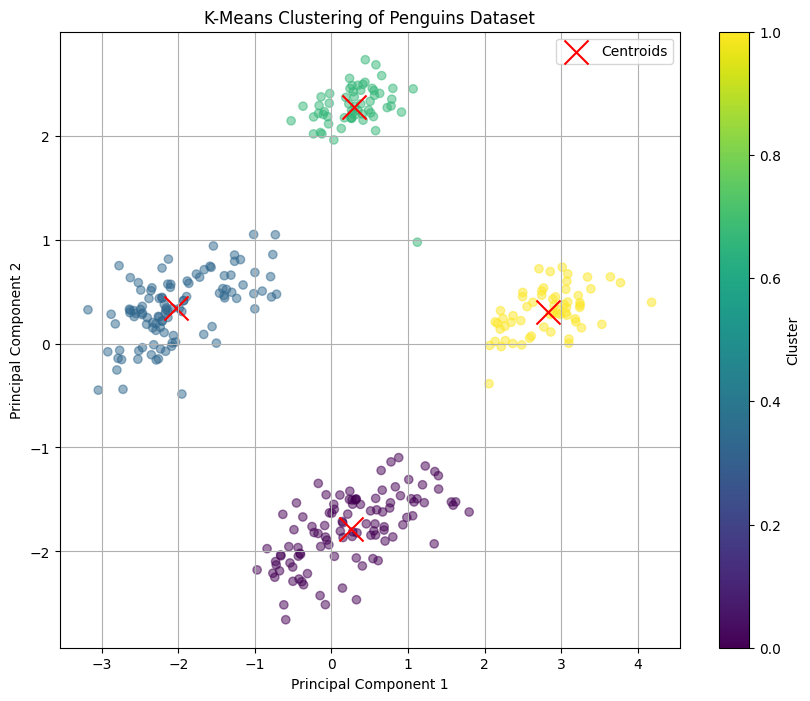

In [232]:
n_clusters = 4  # Adjust based on your observation from the graph
print("Optimal number of clusters:", n_clusters)

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(penguins_PCA)

# Visualize the clusters using the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x', label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Penguins Dataset')
plt.legend()
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

- Add the label column extracted from the k-means clustering (using kmeans.labels_) to the penguins_clean DataFrame.

In [233]:
penguins_clean['label'] = kmeans.labels_
penguins_clean.columns

Index(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex', 'label'],
      dtype='object')

- Create a statistical table by grouping penguins_clean based on the "label" column and calculating the mean of each numeric column. Save this table as stat_penguins

In [234]:
stat_penguins = penguins_clean.groupby(['label']).agg('mean')
stat_penguins

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
label,,,,
0,43.878302,19.111321,194.764151,4006.603774
1,40.217757,17.611215,189.046729,3419.158879
2,45.545763,14.262712,212.779661,4683.050847
3,49.473770,15.718033,221.540984,5484.836066
